# Codice per gli esempi
Iniziamo creando le dovute funzioni e importando il necessario.

In [1]:
from tqdm import tqdm

import numpy as np
np.random.seed(0)  # keep the random seed of numpy fixed

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from time import time

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score

from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn import datasets
from sklearn.datasets import load_wine

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from sklearn.naive_bayes import GaussianNB as GNB

import random

# Configure matplotlib
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def LogisticRegressionMia(data, labels, n_iter = 1000, tol = 1e-7, insert_interc = True):
    
    # Stampiamo il tempo
    # Prendiamo il tempo iniziale
    
    t0 = time()
    
    data_work = data
    
    # Per prima cosa aggiungiamo la colonna per l'intercetta
    if insert_interc:
        data_work = np.insert(data_work, 0, 1, axis = 1)
    
    # Inizialmente proviamo a fissare beta = 0
    beta = np.zeros(len(data_work[0, :]))
    beta_store = [0]
    #print(beta)
    
    # Poi dobbiamo creare il vettore di fitted probabilities p
    p = np.ones(len(labels))
    diagonale = np.zeros(len(labels))
    
    # Ora dobbiamo ripetere queste operazione
    for n in range(n_iter):
        
        # Usiamo i cicli for
        for i in range(len(labels)):
            h = beta @ data_work[i, :]
            elemento = ((np.e)**h) / (1+(np.e)**h)
            #print(elemento)
            #print(np.e**h / (1+np.e**h))
            p[i] = elemento
            #print(p[i])
            diagonale[i] = p[i]*(1 - p[i])
        
        #diagonale[:] = p[:]*(1 - p[:])
            
        #print(p)

        # Ora creiamo la matrice W
        W = np.diagflat(diagonale)
        #print(W)

        # A questo punto definisco il vettore z
        W_inv = np.linalg.inv(W)
        z = np.dot(data_work, beta) + np.dot(W_inv, labels-p)

        # Ora calcolo il nuovo b
        a = np.dot(data_work.T, W)
        c = np.dot(a, data_work)
        d = np.linalg.inv(c)
        f = np.dot(data_work.T, W)
        g = np.dot(d, f)
        beta = np.dot(g, z)
        
        beta_store.append(beta)
        
        if (np.linalg.norm(beta_store[-1] - beta_store[-2]) < tol):
            break
    
    print(f"Regressione effettuata in: {time() - t0} s.")
        
    return beta

In [3]:
def compara_lr(data, labels, data_val = None, y_val = None, n_iter = 1000, tol = 1e-7, 
               insert_interc = True, solver = 'newton-cholesky', penalty = None, train = True):
    
    if train:
        data_train, data_test, labels_train, labels_test = train_test_split(data, labels, train_size = 0.7, random_state = 1)
    else:
        data_train = data
        data_test = data
        labels_train = labels
        labels_test = labels
    
    t0 = time()
    beta = LogisticRegressionMia(data_train, labels_train, n_iter, tol, insert_interc)
    tempo = time() - t0
    print(f"I coefficienti della mia regressione lineare sono dati da: {beta}")
    
    t0 = time()
    logreg = LogisticRegression(solver = solver, penalty = penalty).fit(data_train, labels_train)
    
    tempo1 = time() - t0
    
    print(f"La regressione logistica preimplementata è stata eseguita in: {tempo} s")
    volte = 0
    if (tempo1 > 1e-10):
        volte = tempo / tempo1
        print(f"La mia regressione ci ha messo {volte} volte quella preimplementata")
    else:
        print("I tempi sono troppo piccoli per essere confrontati")
    
    coef_logreg = []
    coef_logreg.append(logreg.intercept_[0])
    for i in range(len(logreg.coef_[0])):
        coef_logreg.append(logreg.coef_[0, i])
    
    print(f"I coefficienti della regressione lineare preimplementata sono dati da: {coef_logreg}")
    
    return beta, coef_logreg

In [4]:
# Funzione per predirre la classe, nel caso di due classi

def predict(data, coef_model, soglia = 0.5, insert_interc = True):
    
    t0 = time()
    
    predict = []
    len_feature = len(data[0])
    data_work = data
    
    if insert_interc:
        data_work = data_work = np.insert(data_work, 0, 1, axis = 1)
        
    # Facciamo un ciclo sui dati che possediamo
    
    for i in range(len(data_work)):
        scalare = np.inner(data_work[i], coef_model)
        prob = np.e**(scalare) / (1 + np.e**(scalare))
        
        if (prob <= soglia):
            predict.append(0)
        else:
            predict.append(1)
    
    print(f"Predizione mia effettuata in: {time() - t0} s.")
    
    return predict

In [5]:

# Compariamo le accuratezze

def calcola_acc_mia(data, pred_real, coef_model, soglia = 0.5, insert_interc = True):
    
    y_pred_mia = predict(data, coef_model, soglia = 0.5, insert_interc = True)
    acc_mia = accuracy_score(pred_real, y_pred_mia)
    
    print(f"Accuratezza della mia predizione: {acc_mia}")
    
# Funzione per confrontare regressione logistica, LDA, QDA e Naive Bayes

def confronta_soglie(X_input, y_input, minval = -2, maxval = 2, plot = True):
    
    logreg_base = LogisticRegression(penalty = None, solver = 'newton-cholesky').fit(X_input, y_input)
    
    X_train1, X_val1, y_train1, y_val1 = train_test_split(X_input, y_input, train_size = 0.7, random_state = 1)
    logreg1 = LogisticRegression(penalty = None, solver = 'newton-cholesky').fit(X_train1, y_train1)
    
    X_train2, X_val2, y_train2, y_val2 = train_test_split(X_input, y_input, train_size = 0.6, random_state = 2)
    logreg2 = LogisticRegression(penalty = None, solver = 'newton-cholesky').fit(X_train2, y_train2)
    
    X_train3, X_val3, y_train3, y_val3 = train_test_split(X_input, y_input, train_size = 0.5, random_state = 3)
    logreg3 = LogisticRegression(penalty = None, solver = 'newton-cholesky').fit(X_train3, y_train3)
    
    LDA_base = LDA().fit(X_input, y_input)
    QDA_base = QDA().fit(X_input, y_input)
    NB_base = GNB().fit(X_input, y_input)
    
    LDA1 = LDA().fit(X_train1, y_train1)
    QDA1 = QDA().fit(X_train1, y_train1)
    NB1 = GNB().fit(X_train1, y_train1)
    
    LDA2 = LDA().fit(X_train2, y_train2)
    QDA2 = QDA().fit(X_train2, y_train2)
    NB2 = GNB().fit(X_train2, y_train2)
    
    LDA3 = LDA().fit(X_train3, y_train3)
    QDA3 = QDA().fit(X_train3, y_train3)
    NB3 = GNB().fit(X_train3, y_train3)
    
    # Predizioni
    y_pred = logreg_base.predict(X_input)
    y_pred_1 = logreg1.predict(X_val1)
    y_pred_2 = logreg2.predict(X_val2)
    y_pred_3 = logreg3.predict(X_val3)
    
    y_pred_lda = LDA_base.predict(X_input)
    y_pred_lda1 = LDA1.predict(X_val1)
    y_pred_lda2 = LDA2.predict(X_val2)
    y_pred_lda3 = LDA3.predict(X_val3)
    
    y_pred_qda = QDA_base.predict(X_input)
    y_pred_qda1 = QDA1.predict(X_val1)
    y_pred_qda2 = QDA2.predict(X_val2)
    y_pred_qda3 = QDA3.predict(X_val3)
    
    y_pred_nb = NB_base.predict(X_input)
    y_pred_nb1 = NB1.predict(X_val1)
    y_pred_nb2 = NB2.predict(X_val2)
    y_pred_nb3 = NB3.predict(X_val3)
    
    # Accuratezze
    
    acc = accuracy_score(y_input, y_pred)
    acc_1 = accuracy_score(y_val1, y_pred_1)
    acc_2 = accuracy_score(y_val2, y_pred_2)
    acc_3 = accuracy_score(y_val3, y_pred_3)
    
    acc_lda = accuracy_score(y_input, y_pred_lda)
    acc_lda1 = accuracy_score(y_val1, y_pred_lda1)
    acc_lda2 = accuracy_score(y_val2, y_pred_lda2)
    acc_lda3 = accuracy_score(y_val3, y_pred_lda3)
    
    acc_qda = accuracy_score(y_input, y_pred_qda)
    acc_qda1 = accuracy_score(y_val1, y_pred_qda1)
    acc_qda2 = accuracy_score(y_val2, y_pred_qda2)
    acc_qda3 = accuracy_score(y_val3, y_pred_qda3)
    
    acc_nb = accuracy_score(y_input, y_pred_nb)
    acc_nb1 = accuracy_score(y_val1, y_pred_nb1)
    acc_nb2 = accuracy_score(y_val2, y_pred_nb2)
    acc_nb3 = accuracy_score(y_val3, y_pred_nb3)
    
    print(f"Accuratezza della logistic regression: {acc}")
    print(f"Accuratezza della logistic regression 1: {acc_1}")
    print(f"Accuratezza della logistic regression 2: {acc_2}")
    print(f"Accuratezza della logistic regression 3: {acc_3}")
    
    print(f"Accuratezza della LDA base: {acc_lda}")
    print(f"Accuratezza della LDA 1: {acc_lda1}")
    print(f"Accuratezza della LDA 2: {acc_lda2}")
    print(f"Accuratezza della LDA 3: {acc_lda3}")
    
    print(f"Accuratezza della QDA base: {acc_qda}")
    print(f"Accuratezza della QDA 1: {acc_qda1}")
    print(f"Accuratezza della QDA 2: {acc_qda2}")
    print(f"Accuratezza della QDA 3: {acc_qda3}")
    
    print(f"Accuratezza della NB base: {acc_nb}")
    print(f"Accuratezza della NB 1: {acc_nb1}")
    print(f"Accuratezza della NB 2: {acc_nb2}")
    print(f"Accuratezza della NB 3: {acc_nb3}")
    
    # Disegni
    
    if plot:
    
        alpha = 0.5
        log_a = np.log((alpha) /  (1 -alpha))

        z_x = np.linspace(minval, maxval, 1000)
        z_y = np.zeros_like(z_x)
        z_y1 = np.zeros_like(z_x)
        z_y2 = np.zeros_like(z_x)
        z_y3 = np.zeros_like(z_x)
        z_y[:] = (log_a - logreg_base.intercept_[0] - logreg_base.coef_[0, 0]*z_x[:]) / (logreg_base.coef_[0,1])
        z_y1[:] = (log_a - logreg1.intercept_[0] - logreg1.coef_[0, 0]*z_x[:]) / (logreg1.coef_[0,1])
        z_y2[:] = (log_a - logreg2.intercept_[0] - logreg2.coef_[0, 0]*z_x[:]) / (logreg2.coef_[0,1])
        z_y3[:] = (log_a - logreg3.intercept_[0] - logreg3.coef_[0, 0]*z_x[:]) / (logreg3.coef_[0,1])

        plt.figure()
        plt.figure(figsize=(8, 8))
        plt.plot(z_x, z_y, label = "DB base")
        plt.plot(z_x, z_y1, label = "DB 1")
        plt.plot(z_x, z_y2, label = "DB 2")
        plt.plot(z_x, z_y3, label = "DB 3")
        plt.plot(X_input[:, 0][y_input == 1], X_input[:, 1][y_input == 1], "g^", label="Classe 1")
        plt.plot(X_input[:, 0][y_input == 0], X_input[:, 1][y_input == 0], "bs", label="Classe 2")
        plt.xlabel("Feature 1", fontsize=14)
        plt.ylabel("Feature 2", fontsize=14)
        plt.legend(loc="upper left", fontsize=10)
        plt.show()


## Iris Dataset
Creiamo ora l'Iris dataset su cui lavoreremo per il resto della Notebook.

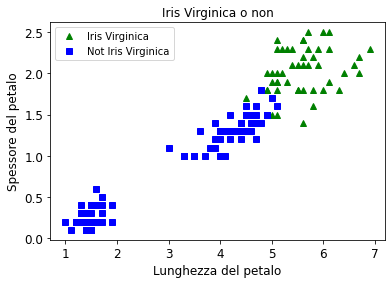

Regressione effettuata in: 0.008973360061645508 s.
I coefficienti della mia regressione lineare sono dati da: [-46.29186415   5.43936559  12.13350819]
La regressione logistica preimplementata è stata eseguita in: 0.011122465133666992 s
La mia regressione ci ha messo 2.4689600423392433 volte quella preimplementata
I coefficienti della regressione lineare preimplementata sono dati da: [-46.28424759876319, 5.4384265982603, 12.131686013552676]


In [6]:
iris = datasets.load_iris()
#print(iris.DESCR)
X_iris, y_iris = iris.data, iris.target

# Prendiamo solo due categorie

X_iris1 = iris["data"][:, (2, 3)]  # petal length, petal width
y_iris1 = (iris["target"] == 2).astype(int)  # make problem binary: 1 if Iris virginica, else 0

plt.figure()
plt.title("Iris Virginica o non")
plt.plot(X_iris1[:, 0][y_iris1 == 1], X_iris1[:, 1][y_iris1 == 1], "g^", label="Iris Virginica")
plt.plot(X_iris1[:, 0][y_iris1 == 0], X_iris1[:, 1][y_iris1 == 0], "bs", label="Not Iris Virginica")
plt.xlabel("Lunghezza del petalo", fontsize=12)
plt.ylabel("Spessore del petalo", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.show()

beta_iris, coef_iris = compara_lr(X_iris1, y_iris1)

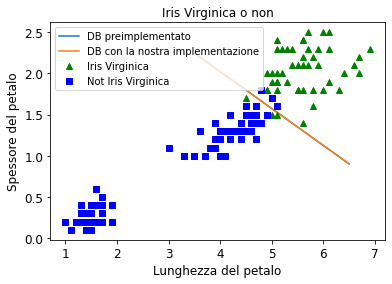

In [7]:
# Visualizziamo graficamente il risultato

alpha = 0.5
log_a = np.log((alpha) /  (1 -alpha))

z_x = np.linspace(3.5, 6.5, 1000)
z_y = np.zeros_like(z_x)
z_y[:] = (log_a - coef_iris[0] - coef_iris[1]*z_x[:]) / (coef_iris[2])

z_y1  = (log_a - beta_iris[0] - beta_iris[1]*z_x[:]) / beta_iris[2]


plt.figure()
plt.title("Iris Virginica o non")
plt.plot(z_x, z_y, label = "DB preimplementato")
plt.plot(z_x, z_y1, label = "DB con la nostra implementazione")
plt.plot(X_iris1[:, 0][y_iris1 == 1], X_iris1[:, 1][y_iris1 == 1], "g^", label="Iris Virginica")
plt.plot(X_iris1[:, 0][y_iris1 == 0], X_iris1[:, 1][y_iris1 == 0], "bs", label="Not Iris Virginica")
# plt.imshow(Z, origin = 'lower', 
#            extent = (4, 6, 0, 3),
#            alpha = 0.4)
plt.xlabel("Lunghezza del petalo", fontsize=12)
plt.ylabel("Spessore del petalo", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.show()

Vediamo già ora i risultati del capitolo sui modelli generativi: in particolare riporteremo i risultati ottenuti con i metodi indicati dal numero 1.

In [8]:
confronta_soglie(X_iris, y_iris, plot = False)

Accuratezza della logistic regression: 0.98
Accuratezza della logistic regression 1: 0.9555555555555556
Accuratezza della logistic regression 2: 0.95
Accuratezza della logistic regression 3: 0.92
Accuratezza della LDA base: 0.98
Accuratezza della LDA 1: 1.0
Accuratezza della LDA 2: 1.0
Accuratezza della LDA 3: 0.96
Accuratezza della QDA base: 0.98
Accuratezza della QDA 1: 1.0
Accuratezza della QDA 2: 0.9833333333333333
Accuratezza della QDA 3: 0.9333333333333333
Accuratezza della NB base: 0.96
Accuratezza della NB 1: 0.9333333333333333
Accuratezza della NB 2: 0.9333333333333333
Accuratezza della NB 3: 0.96


## Dataset con make_classification
Creiamo ora il dataset che useremo per vedere come si comporta la regressione logistica verso nuovi dati.

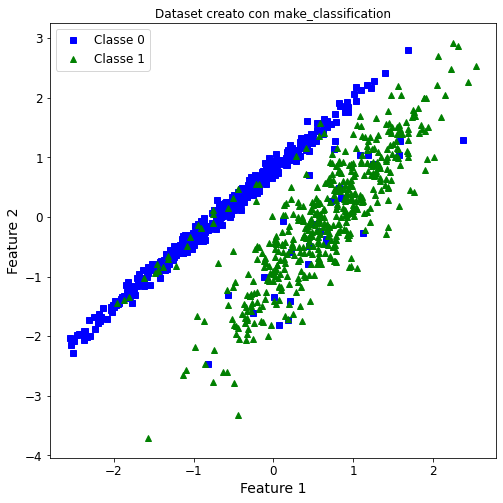

In [9]:
X_cluster, y_cluster = datasets.make_classification(n_samples=1000,
                                                    n_features=2,
                                                    n_redundant=0,
                                                    n_informative=2,
                                                    n_repeated=0,
                                                    n_clusters_per_class=1,
                                                    flip_y=0.1,
                                                    random_state=15,
                                                    )
# Scaliamo i dati
scaler = StandardScaler()
X_cluster = scaler.fit_transform(X_cluster)

plt.figure(figsize=(8, 8))
plt.title('Dataset creato con make_classification')
plt.plot(X_cluster[:, 0][y_cluster == 0], X_cluster[:, 1][y_cluster == 0], "bs", label = 'Classe 0')
plt.plot(X_cluster[:, 0][y_cluster == 1], X_cluster[:, 1][y_cluster == 1], "g^", label = 'Classe 1')
plt.xlabel('Feature 1', fontsize=14)
plt.ylabel('Feature 2', fontsize=14)
plt.legend(loc = 'best', fontsize = 12)
plt.show()

In [10]:
beta0, coef0 = compara_lr(X_cluster, y_cluster)

y_pred0 = predict(X_cluster, beta0)
acc0 = accuracy_score(y_cluster, y_pred0)
print(acc0)

Regressione effettuata in: 0.14293932914733887 s.
I coefficienti della mia regressione lineare sono dati da: [ 0.44232809  4.04559985 -2.99798067]
La regressione logistica preimplementata è stata eseguita in: 0.14638781547546387 s
La mia regressione ci ha messo 45.45417530352384 volte quella preimplementata
I coefficienti della regressione lineare preimplementata sono dati da: [0.44229696426344867, 4.045549972840835, -2.99792787559527]
Predizione mia effettuata in: 0.005027294158935547 s.
0.938


In [11]:
confronta_soglie(X_cluster, y_cluster, plot = False)

Accuratezza della logistic regression: 0.937
Accuratezza della logistic regression 1: 0.9266666666666666
Accuratezza della logistic regression 2: 0.9475
Accuratezza della logistic regression 3: 0.93
Accuratezza della LDA base: 0.934
Accuratezza della LDA 1: 0.9266666666666666
Accuratezza della LDA 2: 0.945
Accuratezza della LDA 3: 0.928
Accuratezza della QDA base: 0.937
Accuratezza della QDA 1: 0.93
Accuratezza della QDA 2: 0.95
Accuratezza della QDA 3: 0.93
Accuratezza della NB base: 0.792
Accuratezza della NB 1: 0.7533333333333333
Accuratezza della NB 2: 0.795
Accuratezza della NB 3: 0.796


La seguente funzione crea i dataset sbilanciati e fitta su questi una regressione logistica.

In [12]:
def soglie(X_dati, y_dati, classe0 = 50, classe1 = 450, plot = True, x_min = -3, x_max = 3,
                  title = "Confronto sull'intero dataset", xlabel = "Feature 1", ylabel = "Feature 2"):
    
    # Calcoliamo i coefficienti base
    
    beta0, coef0 = compara_lr(X_dati, y_dati)
    
    # Sbilanciamo il dataset
    
    caso = []
    for i in range(len(y_dati)):
        if y_dati[i] == 1:
            caso.append(i)
    casual = random.sample(caso, classe1)

    caso2 = []
    for i in range(len(y_dati)):
        if y_dati[i] == 0:
            caso2.append(i)
    casual2 = random.sample(caso2, classe0)

    train = []
    for i in range(len(casual)):
        train.append(casual[i])

    for i in range(len(casual2)):
        train.append(casual2[i])

    print(len(train))

    X_train = X_dati[train, :]
    y_train = y_dati[train]
    
    plt.figure(figsize=(8, 8))
    plt.plot(X_train[:, 0][y_train == 0], X_train[:, 1][y_train == 0], "bs", label = f"Classe 0: {classe0}")
    plt.plot(X_train[:, 0][y_train == 1], X_train[:, 1][y_train == 1], "g^", label = f"Classe 1: {classe1}")
    plt.xlabel('Feature 1', fontsize=14)
    plt.ylabel('Feature 2', fontsize=14)
    plt.title('Dati usati come training')
    plt.legend(loc="best", fontsize=12)
    plt.show()

    beta, coef_logreg = compara_lr(X_train, y_train, train = False)

    y_pred_mia = predict(X_dati, beta)
    acc = accuracy_score(y_dati, y_pred_mia)
    print(f"L'accuratezza è data da {acc}")
    
    
    if plot:
        
        alpha = 0.5
        log_a = np.log((alpha) /  (1 -alpha))

        z_x = np.linspace(x_min, x_max, 1000)
        z_y = np.zeros_like(z_x)
        z_y[:] = (log_a - beta[0] - beta[1]*z_x[:]) / (beta[2])

        z_y1  = (log_a - beta0[0] - beta0[1]*z_x[:]) / beta0[2]


        plt.figure()
        plt.figure(figsize=(8, 8))
        plt.title(title)
        plt.plot(z_x, z_y, label = "DB dataset modificato")
        plt.plot(z_x, z_y1, label = "DB col dataset diviso equamente")
        plt.plot(X_dati[:, 0][y_dati == 1], X_dati[:, 1][y_dati == 1], "g^", label="Classe 1")
        plt.plot(X_dati[:, 0][y_dati == 0], X_dati[:, 1][y_dati == 0], "bs", label="Classe 0")
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.legend(loc="best", fontsize=12)
        plt.show()

Regressione effettuata in: 0.14530682563781738 s.
I coefficienti della mia regressione lineare sono dati da: [ 0.44232809  4.04559985 -2.99798067]
La regressione logistica preimplementata è stata eseguita in: 0.15746736526489258 s
La mia regressione ci ha messo 33.119346103700735 volte quella preimplementata
I coefficienti della regressione lineare preimplementata sono dati da: [0.44229696426344867, 4.045549972840835, -2.99792787559527]
500


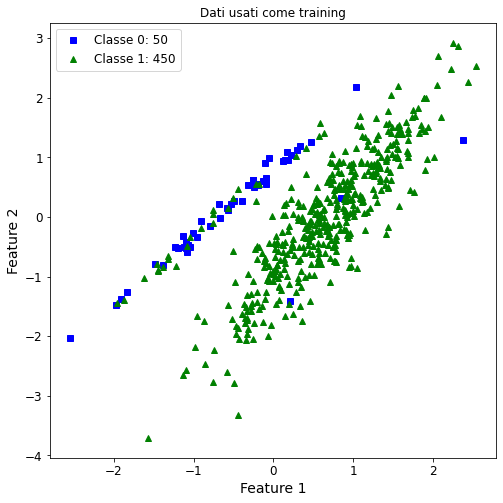

Regressione effettuata in: 0.0884859561920166 s.
I coefficienti della mia regressione lineare sono dati da: [ 2.49255214  4.05769418 -3.35127503]
La regressione logistica preimplementata è stata eseguita in: 0.0884859561920166 s
La mia regressione ci ha messo 9.778085151227737 volte quella preimplementata
I coefficienti della regressione lineare preimplementata sono dati da: [2.489468971760456, 4.0531456713938505, -3.3467559475439335]
Predizione mia effettuata in: 0.0040283203125 s.
L'accuratezza è data da 0.874


<Figure size 432x288 with 0 Axes>

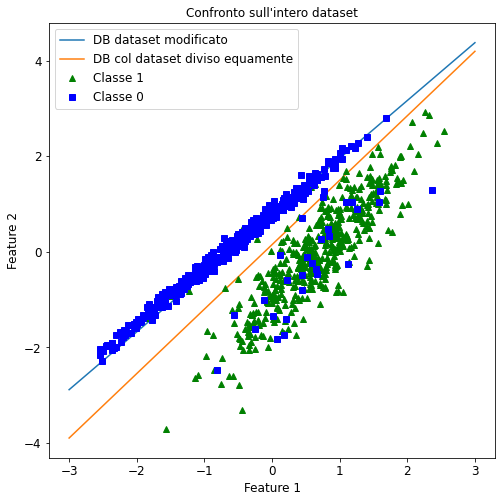

In [13]:
soglie(X_cluster, y_cluster)

Regressione effettuata in: 0.1315770149230957 s.
I coefficienti della mia regressione lineare sono dati da: [ 0.44232809  4.04559985 -2.99798067]
La regressione logistica preimplementata è stata eseguita in: 0.14727067947387695 s
La mia regressione ci ha messo 67.7746324336186 volte quella preimplementata
I coefficienti della regressione lineare preimplementata sono dati da: [0.44229696426344867, 4.045549972840835, -2.99792787559527]
500


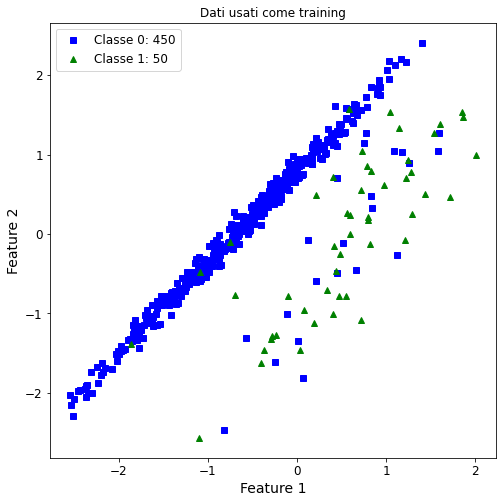

Regressione effettuata in: 0.09143924713134766 s.
I coefficienti della mia regressione lineare sono dati da: [-1.70820914  3.48879559 -2.27174249]
La regressione logistica preimplementata è stata eseguita in: 0.09143924713134766 s
La mia regressione ci ha messo 20.874326457301475 volte quella preimplementata
I coefficienti della regressione lineare preimplementata sono dati da: [-1.706119452600426, 3.484806359675131, -2.2703728023873673]
Predizione mia effettuata in: 0.0029931068420410156 s.
L'accuratezza è data da 0.828


<Figure size 432x288 with 0 Axes>

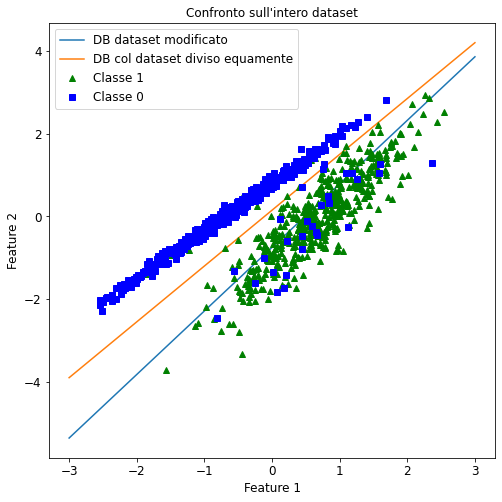

In [14]:
soglie(X_cluster, y_cluster, classe1 = 50, classe0 = 450)

## Modelli generativi
Vediamo un esempio sui modelli generativi. Creiamo il Two Circles Dataset e utilizziamo la funzione che ho chiamato confronta_soglie: nell'elaborato ho riportato i dati ottenuti dai modelli indicati con 1.

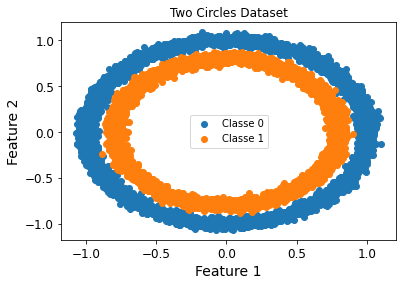

In [15]:
X_circles, y_circles = make_circles(n_samples = 10000, noise = 0.03, random_state = 1)

# Visualizzare il dataset
plt.scatter(X_circles[y_circles == 0][:, 0], X_circles[y_circles == 0][:, 1], label="Classe 0")
plt.scatter(X_circles[y_circles == 1][:, 0], X_circles[y_circles == 1][:, 1], label="Classe 1")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title('Two Circles Dataset')
plt.legend()
plt.show()

In [16]:
confronta_soglie(X_circles, y_circles, minval = -1, maxval = 1, plot = False)

Accuratezza della logistic regression: 0.5006
Accuratezza della logistic regression 1: 0.48733333333333334
Accuratezza della logistic regression 2: 0.4825
Accuratezza della logistic regression 3: 0.4746
Accuratezza della LDA base: 0.5006
Accuratezza della LDA 1: 0.48733333333333334
Accuratezza della LDA 2: 0.4825
Accuratezza della LDA 3: 0.4746
Accuratezza della QDA base: 0.9992
Accuratezza della QDA 1: 0.9973333333333333
Accuratezza della QDA 2: 0.9935
Accuratezza della QDA 3: 0.9912
Accuratezza della NB base: 0.9992
Accuratezza della NB 1: 0.9966666666666667
Accuratezza della NB 2: 0.995
Accuratezza della NB 3: 0.9904


In [17]:
t0 = time()

X_circles_train, X_circles_test, y_circles_train, y_circles_test = train_test_split(X_circles,
                                                                                   y_circles,
                                                                                   train_size = 0.7, random_state = 10)

QDA_circles = QDA().fit(X_circles_train, y_circles_train)
y_pred_qda = QDA_circles.predict(X_circles_test)
acc_qda = accuracy_score(y_circles_test, y_pred_qda)

tempo_esecuzione = time() - t0

print(f"Accuratezza: {acc_qda}")
print(f"Operazione quadratica eseguita in {tempo_esecuzione} s")

t0 = time()

# Per prima cosa creo il valore x**2

X1 = np.insert(X_circles, 2, 0, axis = 1)
X1 = np.insert(X1, 3, 0, axis = 1)
X1 = np.insert(X1, 4, 0, axis = 1)

# Nella terza metto x^2
X1[:, 2] = (X1[:, 0])**2

# Nella quarta metto y^2
X1[:, 3] = (X1[:, 1])**2

# Nella quinta metto xy
X1[:, 4] = (X1[:, 0])*(X1[:, 1])

#print(X1)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1,
                                                        y_circles,
                                                        train_size = 0.7, random_state = 1)

# A questo punto creo una regressione logistica su questi parametri
logreg1 = LogisticRegression(penalty = None)
logreg1.fit(X1_train, y1_train)
y_pred_circles = logreg1.predict(X1_test)
acc_circles = accuracy_score(y1_test, y_pred_circles)

tempo_esecuzione2 = time() - t0

volte = tempo_esecuzione2 / tempo_esecuzione

print(f"Accuratezza: {acc_circles}")
print(f"Operazione quadratica eseguita in {tempo_esecuzione} s")
print(f"Corrisponde a {volte} volte")


Accuratezza: 0.994
Operazione quadratica eseguita in 0.004670858383178711 s
Accuratezza: 0.9986666666666667
Operazione quadratica eseguita in 0.004670858383178711 s
Corrisponde a 4.098463580215405 volte
